In [1]:
from math import pi
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(12,8)

In [2]:
import numpy as npa # to avoid interfering with Pennylane numpy
# npa.__version__
# '1.20.0'
from numpy.random import default_rng
# rng = default_rng(seed) # seed for reproducibility

In [3]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer
from qiskit import BasicAer #, Aer  ## BasicAer in python - Aer in C++
from qiskit.circuit import Parameter
# from qiskit.aqua.operators.gradients import Gradient, NaturalGradient#, QFI, Hessian

# backend = Aer.get_backend('unitary_simulator')
# backend = Aer.get_backend('statevector_simulator')
from qiskit.providers.aer import StatevectorSimulator
backend = StatevectorSimulator(zero_threshold=1e-6)

from qiskit.visualization import plot_bloch_multivector
# from qiskit_textbook.widgets import plot_bloch_vector_spherical

## State preparation with qiskit

### General rotation - arbitrary pure state on Bloch sphere

{Parameter(ϕ), Parameter(θ), Parameter(λ)}


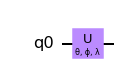

In [4]:
theta = Parameter('θ')
phi = Parameter('ϕ')
lam = Parameter('λ')
backend = StatevectorSimulator(zero_threshold=1e-6)
q = QuantumRegister(1)
qc = QuantumCircuit(q)
params = (theta, phi, lam)
qc.u(*params,q)
print(qc.parameters)
qc.draw('mpl')

In [5]:
# function creating a circuit that rotates the initial |0> state to any pure state with general rotation gate U((θ, ϕ, λ) 
def qc_general(theta, phi, lam, q):
    qc = QuantumCircuit(q)
    qc.u(theta, phi, lam,q)
    return qc

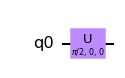

In [6]:
##unit test
params = (pi/2, 0, 0) # |+>
test_qc = qc_general(*params, q)
test_qc.draw('mpl')

In [7]:
job = execute(test_qc, backend)
# job.result().get_unitary(qc, decimals=2)
result = job.result()
outputstate = result.get_statevector(test_qc, decimals=3)
print(outputstate)

[0.70710678+0.j 0.70710678+0.j]


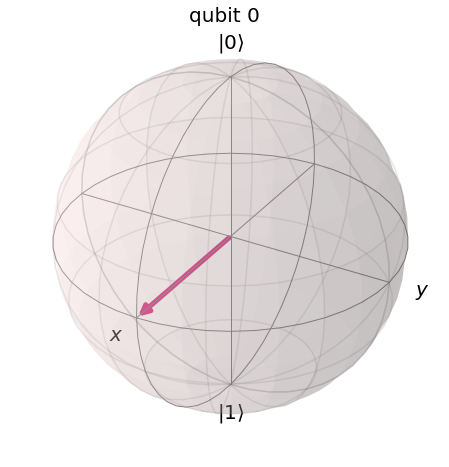

In [8]:
plot_bloch_multivector(outputstate)

### Random pure states in a region of the sphere surface

> Quantum cats: region around |+>

> Quantum dogs: region around |+i>

In [9]:
# distribution = 'uniform'
distribution = 'normal'

In [10]:
def random_qstates(theta_1, theta_2, phi_1, phi_2, qreg, rng_seed=None, distr='uniform', size=10):
    '''
    Creates a list of random pure state vectors starting from initial state |0> 
    applying general rotation U3(θ, ϕ, λ) with angles drawn from either a uniform distribution
    with some restricted range [a,b] obtained with (b - a) * random() + a
    or a normal distribution with mean/variance
    '''
    ## pick parameters at random
    rng = default_rng(rng_seed)
    params = (theta, phi, lam, qreg)
    state = []
    x, y, z = [], [], []
    
    if distr=='uniform':
        θ = rng.random(size)*(theta_2-theta_1)+theta_1
        ϕ = rng.random(size)*(phi_2-phi_1)+phi_1
        λ = rng.random(size)*2*pi
    elif distr=='normal':
        θ = rng.normal(loc=theta_1, scale=theta_2, size=size)
        ϕ = rng.normal(loc=phi_1, scale=phi_2, size=size)
        λ = rng.random(size)*2*pi
        
    angles = [list(a) for a in zip(θ, ϕ, λ)]

    x = npa.sin(θ)*npa.cos(ϕ)
    y = npa.sin(θ)*npa.sin(ϕ)
    z = npa.cos(θ)
    coords = [c for c in zip(x, y, z)]
        
    for i in range(size):
        random_qc = qc_general(*params).bind_parameters({theta: θ[i], phi: ϕ[i], lam: λ[i]})
        job = execute(random_qc, backend)
        result = job.result()
        outputstate = result.get_statevector(random_qc, decimals=3)
        state.append(outputstate)
    return state, coords, angles

In [11]:
# random_qstates(pi/8, 3*pi/8, 3*pi/8, pi/2, q, 123, 'uniform', 2)

In [12]:
# random_qstates(pi/2, pi/10, 0, pi/10, q, 123, 'normal', 2)

In [13]:
state, coords, angles = random_qstates(theta_1=pi / 8,
                                       theta_2=3 * pi / 8,
                                       phi_1=3 * pi / 8,
                                       phi_2=pi / 2,
                                       qreg=q,
                                       rng_seed=123,
                                       size=2)
print(state)
print(coords)
print(angles)

[array([0.89413144+0.j        , 0.13496975+0.42698025j]), array([0.97644321+0.j        , 0.06793618+0.20480072j])]
[(0.24136139016134603, 0.7635529333404171, 0.5989420650836165), (0.13267163365998316, 0.39995255110489913, 0.9068826795604128)]
[[0.9286169818846428, 1.2646323647772246, 1.1052493731436484], [0.43497001101816934, 1.2504998858486711, 5.1025402722608115]]


In [14]:
# (theta_1, theta_2, phi_1, phi_2) = (pi/8, .1, 3*pi/8, .1)
(theta_1, theta_2, phi_1, phi_2) = (pi/2, pi/10, 0, pi/10) # |+> |->
(theta_1, theta_2, phi_1, phi_2) = (pi/2, pi/2, 0, pi/10) # |+> |->
state, coords, angles = random_qstates(theta_1,
                                       theta_2,
                                       phi_1,
                                       phi_2,
                                       qreg=q,
                                       rng_seed=123,
                                       distr='normal',
                                       size=2)
print(state)
print(coords)
print(angles)

[array([0.8080114 +0.j        , 0.54159431+0.23193357j]), array([0.7467552 +0.j        , 0.66386444+0.04050529j])]
[(0.8752287577377009, 0.3748099323942687, 0.30576483808234817), (0.9914884418382894, 0.060495078626660766, 0.11528666515705642)]
[[1.2600546900187342, 0.40461365392390186, 1.1052493731436484], [1.4552527425609074, 0.0609388610131365, 5.1025402722608115]]


In [15]:
def plot_two_groups_of_qstates(theta_1,
                               theta_2,
                               phi_1,
                               phi_2,
                               qreg,
                               rng_seed=None,
                               distr='uniform', #'uniform' or 'normal'
                               size=10):
    # Create a sphere
    r = 1
    phi, theta = npa.mgrid[0.0:pi:100j, 0.0:2.0 * pi:100j]
    xs = r * npa.sin(phi) * npa.cos(theta)
    ys = r * npa.sin(phi) * npa.sin(theta)
    zs = r * npa.cos(phi)

    ## x, y are swapped in the visualization

    ## QCATS as pure states on the Bloch sphere
    qcats, cats_coords, cats_angles = random_qstates(theta_1[0],
                                                     theta_2[0],
                                                     phi_1[0],
                                                     phi_2[0],
                                                     qreg,
                                                     rng_seed[0],
                                                     distr,
                                                     size=size)
    y0, x0, z0 = [c[0] for c in cats_coords], [c[1] for c in cats_coords
                                               ], [c[2] for c in cats_coords]

    ## QDOGS as pure states on the Bloch sphere
    qdogs, dogs_coords, dogs_angles = random_qstates(theta_1[1],
                                                     theta_2[1],
                                                     phi_1[1],
                                                     phi_2[1],
                                                     qreg,
                                                     rng_seed[1],
                                                     distr,
                                                     size=size)
    y1, x1, z1 = [c[0] for c in dogs_coords], [c[1] for c in dogs_coords
                                               ], [c[2] for c in dogs_coords]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.grid(False)
    ax.set_xlabel('Y')
    ax.set_ylabel('X')
    ax.set_zlabel('Z')

    ax.set_xlim(-1, 1)
    ax.set_ylim(1, -1)
    ax.set_zlim(-1, 1)

    ax.plot_surface(xs,
                    ys,
                    zs,
                    rstride=1,
                    cstride=1,
                    color='aliceblue',
                    alpha=0.4,
                    linewidth=0)

    # ax.plot(npa.array([0, 0, 0]), npa.array([1.5, 0, 0]))
    ax.quiver(0, 0, 0, 0, 1.4, 0, arrow_length_ratio=.1)
    ax.quiver(0, 0, 0, 1.4, 0, 0, arrow_length_ratio=.1)
    ax.quiver(0, 0, 0, 0, 0, 1.4, arrow_length_ratio=.1)
    ax.scatter(x0, y0, z0, marker='o', c='r')
    ax.scatter(x1, y1, z1, marker='o', c='darkblue')
    plt.show()

    return qcats, qdogs, cats_angles, dogs_angles

<div class="alert alert-block alert-info">
qcats and qdogs are the respective qiskit state vectors
</div>

In [16]:
## size of the full dataset
size = 2500

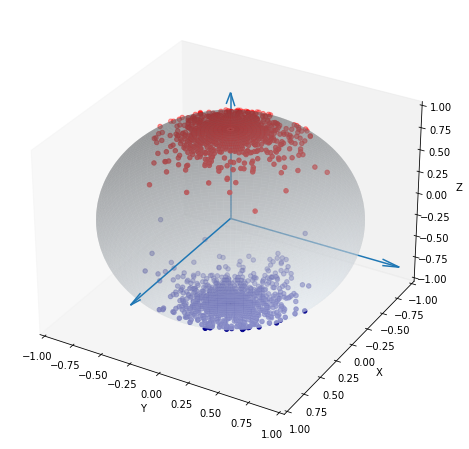

In [29]:
# squeeze = .65
# qcats, qdogs, cats_angles, dogs_angles = plot_two_groups_of_qstates(
#     theta_1=[pi / 6, pi / 3],
#     theta_2=[pi/2*squeeze, 3*pi/4*squeeze],
#     phi_1=[-pi / 5, pi / 4],
#     phi_2=[pi/5*squeeze, 2*pi/3*squeeze],
#     qreg=q,
#     rng_seed=[123, 456],
#     distr=distribution, #'uniform'
#     size=int(size/2))

# qcats, qdogs, cats_angles, dogs_angles = plot_two_groups_of_qstates(
#     theta_1=[pi / 5, pi / 3],
#     theta_2=[.4, .3],
#     phi_1=[-pi / 5, pi / 3],
#     phi_2=[.4, .3],
#     qreg=q,
#     rng_seed=[123, 456],
#     distr=distribution, #'normal',
#     size=int(size/2))

suffix = 'z_poles'
(theta_1, theta_2, phi_1, phi_2) = ([0, pi], [pi/12, pi/12], [0, 0], [2*pi, 2*pi]) # |0> |1>

# suffix = 'x_poles'
# (theta_1, theta_2, phi_1, phi_2) = ([pi/2, pi/2], [pi/12, pi/12], [0, pi], [pi/12, pi/12]) # |+> |->

# suffix = 'y_poles'
# (theta_1, theta_2, phi_1, phi_2) = ([pi/2, pi/2], [pi/12, pi/12], [pi/2, -pi/2], [pi/12, pi/12]) # |+i> |-i>


qcats, qdogs, cats_angles, dogs_angles = plot_two_groups_of_qstates(
    theta_1, theta_2, phi_1, phi_2,
    qreg=q,
    rng_seed=[123, 456],
    distr=distribution, #'normal',
    size=int(size/2))

# qcats are the red points and qdogs are the blue points

In [30]:
# size=125
cats_angles_label = [d[0]+d[1] for d in [c for c in zip(cats_angles, [['qat']]*size)]]
dogs_angles_label = [d[0]+d[1] for d in [c for c in zip(dogs_angles, [['doq']]*size)]]

In [31]:
## training/test - 80%/20%
train_size = int(size/2*.8)
test_size = int(size/2*.2)
import random
random.seed(789)
training_data = cats_angles_label[0:train_size] + dogs_angles_label[0:train_size]
random.shuffle(training_data)
testing_data = cats_angles_label[train_size:] + dogs_angles_label[train_size:]
random.shuffle(testing_data)
# training_data
# testing_data

In [32]:
npa.savetxt('training_data_xyz_'+distribution+'_'+suffix+'.csv', training_data, fmt='%s', delimiter=',')
npa.savetxt('testing_data_xyz_'+distribution+'_'+suffix+'.csv', testing_data, fmt='%s', delimiter=',')

<div class="alert alert-block alert-info">

Possible next step:
    draw from a non-uniform distribution with bias to get some overlap
</div>

## State preparation with PennyLane

In [19]:
import pennylane as qml
from pennylane import numpy as np

### General rotation

In [20]:
def simulate_circuit(theta, phi, lam):
    dev = qml.device("default.qubit", wires=1)
    params = (theta, phi, lam)
    @qml.qnode(dev)
    def circuit(theta, phi, lam):
        qml.U3(theta, phi, lam, wires=0)
        return qml.expval(qml.PauliZ(0))
    circuit(*params)
    return dev.state, params

In [21]:
## unit test
params = (pi/2, 0,0) # |+>
state_init, _ = simulate_circuit(*params)
state_init

tensor([0.70710678+0.j, 0.70710678+0.j], requires_grad=True)

In [22]:
## unit test combining angles from previous function
state_ref, _, params = random_qstates(theta_1=pi / 8,
                                      theta_2=3 * pi / 8,
                                      phi_1=3 * pi / 8,
                                      phi_2=pi / 2,
                                      qreg=q,
                                      rng_seed=123,
                                      distr='uniform',
                                      size=1)
print(params[0])
print(state_ref)
state_init, _ = simulate_circuit(*params[0])
state_init

[0.9286169818846428, 1.199232709755895, 1.3845619148968347]
[array([0.89413144+0.j        , 0.16258567+0.41724677j])]


tensor([0.89413144+0.j        , 0.16258567+0.41724677j], requires_grad=True)

In [23]:
## unit test combining angles from previous function
state_ref, _, params = random_qstates(theta_1=pi / 8,
                                      theta_2=.4,
                                      phi_1=3 * pi / 8,
                                      phi_2=.2,
                                      qreg=q,
                                      rng_seed=123,
                                      distr='normal',
                                      size=1)
print(params[0])
print(state_ref)
state_init, _ = simulate_circuit(*params[0])
state_init

[-0.0029494584404162194, 1.1045399148025958, 1.3845619148968347]
[array([ 9.99998913e-01+0.j        , -6.62957579e-04-0.00131731j])]


tensor([ 9.99998913e-01+0.j        , -6.62957579e-04-0.00131731j], requires_grad=True)

<div class="alert alert-block alert-info">

To generate the states, we only need the angles
</div>

In [24]:
def pet_states(angles):
    pet_states = []
    for a in angles: 
        state, _ = simulate_circuit(*a)
        pet_states.append(state)
    return pet_states

In [25]:
cat_states = pet_states(cats_angles)
cat_states[:5]

[tensor([0.79248565-1.11022302e-16j, 0.60690588-6.02638997e-02j], requires_grad=True),
 tensor([0.74031669+0.j        , 0.65139862+0.16616568j], requires_grad=True),
 tensor([0.57843524+0.j        , 0.78756385-0.21249908j], requires_grad=True),
 tensor([0.6889265 +0.j        , 0.72375658+0.03945495j], requires_grad=True),
 tensor([0.61701209+0.j        , 0.74631103+0.24963159j], requires_grad=True)]

In [26]:
# dog_states = pet_states(dogs_angles)
# dog_states[:5]

In [27]:
# cats_angles[:5]

In [28]:
# size=125
# [d[0]+d[1] for d in [c for c in zip(cats_angles, [['qat']]*size)]]

In [29]:
# size=125
cats_angles_label = [d[0]+d[1] for d in [c for c in zip(cats_angles, [['qat']]*size)]]
dogs_angles_label = [d[0]+d[1] for d in [c for c in zip(dogs_angles, [['doq']]*size)]]

In [30]:
cats_angles_label[0]

[1.3118449628147613, -0.09897250914199643, 1.3690751841136621, 'qat']

In [29]:
## training/test - 80%/20%
train_size = int(size/2*.8)
test_size = int(size/2*.2)
import random
random.seed(789)
training_data = cats_angles_label[0:train_size] + dogs_angles_label[0:train_size]
random.shuffle(training_data)
testing_data = cats_angles_label[train_size:] + dogs_angles_label[train_size:]
random.shuffle(testing_data)
# training_data
testing_data

[[1.5462780259565174, 0.4822827727617035, 3.6034579680922683, 'doq'],
 [0.8544653808570416, -1.1279351073235988, 0.4970046861384084, 'qat'],
 [1.246519524285613, 0.9935626376443315, 1.3580928345511347, 'doq'],
 [0.2690315825722384, -0.8056691493542495, 4.200890084850684, 'qat'],
 [0.9209394035370482, 1.0267266565211, 2.078690966055837, 'doq'],
 [0.30920363461243294, -0.20872202416749563, 1.3595380699486428, 'qat'],
 [1.1023227199539987, 0.5833669581442671, 3.0431815311710273, 'doq'],
 [0.3859307862253909, -0.5727574625878699, 2.60024997425305, 'qat'],
 [0.91635764894793, 1.3087502251066645, 6.275935513901427, 'doq'],
 [0.4089903898443209, 0.7811064530174837, 4.5648619298746365, 'doq'],
 [0.9486893369142548, 0.9324800092781262, 0.8146186584765277, 'doq'],
 [1.2727854815733817, 1.087269901031966, 3.6665810989913226, 'doq'],
 [0.8473526320777138, 0.9185569587816331, 4.922757170876843, 'doq'],
 [1.3930776441609818, 1.2268872285945085, 0.6129194172203468, 'doq'],
 [0.827391319210936, -1.170

In [30]:
npa.savetxt('cats_angles_'+distribution+'.csv', cats_angles)
npa.savetxt('dogs_angles_'+distribution+'.csv', dogs_angles)

In [31]:
npa.savetxt('training_data_xyz_'+distribution+'.csv', training_data, fmt='%s', delimiter=',')
npa.savetxt('testing_data_xyz_'+distribution+'.csv', testing_data, fmt='%s', delimiter=',')

<div class="alert alert-block alert-info">

To recreate the states, we only need the angles and we use function *simulate_circuit()*
</div>

In [32]:
same_cats = npa.loadtxt('cats_angles_'+distribution+'.csv')
same_cats[:5]

array([[ 0.23266999, -0.77953739,  1.36907518],
       [ 0.48120387, -0.24670714,  4.77912715],
       [ 1.14348864, -1.03098166,  0.13853165],
       [ 0.7059083 , -0.54510946,  5.17271583],
       [ 0.99641089, -0.13513357,  0.09613288]])

In [33]:
## re-upload the states
simulate_circuit(*same_cats[0])

(tensor([0.99324071+0.j       , 0.08255545-0.0815934j], requires_grad=True),
 (0.23266999057881826, -0.7795373856954614, 1.3690751841136621))

### [test] Arbitrary state preparation

> making use of Pauli rotations (generalised to n wires)

In [37]:
dev = qml.device("default.qubit", wires=1)

@qml.template
def ansatz(weights):
    qml.templates.ArbitraryStatePreparation(weights, wires=0)


In [50]:
@qml.qnode(dev)
def experiment(weights):
    ansatz(weights[:NUM_ANSATZ_PARAMETERS])

    return dev.state

In [51]:
def simulate_circuit(weights):
    dev = qml.device("default.qubit", wires=1)
    @qml.qnode(dev)
    def experiment(weights):
        ansatz(weights[:NUM_ANSATZ_PARAMETERS])
        return qml.expval(qml.PauliZ(0))
    experiment(weights)
    return dev.state, weights

In [77]:
n = 1
NUM_ANSATZ_PARAMETERS = 2**(n+1)-2
rng = default_rng()

weights = rng.random(NUM_ANSATZ_PARAMETERS)*2*pi
weights

array([2.36250176, 1.88879379])

In [78]:
outputstate, weights = simulate_circuit(weights)
weights

array([2.36250176, 1.88879379])

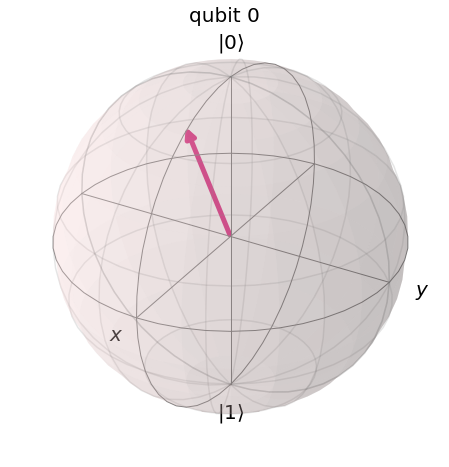

In [79]:
plot_bloch_multivector(outputstate)